In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import xarray as xr 

from include.neural_net import NeuralNet

In [2]:
#weathermob_data = torch.from_numpy(pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0).to_numpy(dtype=float)).float().reshape(-1, 2, 1)
weathermob_df = pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0)
weathermob_data = weathermob_df
#weathermob_data["outdoorFraction"] = abs(weathermob_data["outdoorFraction"] - 1)
weathermob_data = torch.from_numpy(weathermob_df.to_numpy(dtype=float)).float().reshape(-1, 2, 1)
weathermob_df.index = pd.to_datetime(weathermob_df.index)

#data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)
data = pd.read_csv("../../data/Covid_lessdat/Berlin_data/data.csv", index_col=0, parse_dates=True)
# Preprocess the data


In [3]:
data = data.iloc[:300]
data

,susceptible,exposed,infected,recovered,symptomatic,hospitalized,critical,deceased,quarantine_S,quarantine_E,quarantine_I,contact_traced
2020-03-03,0.999998,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-04,0.999997,0,0.000001,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-05,0.999995,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-06,0.999993,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-07,0.999990,0,0.000003,5.287925e-07,0,0,0,5.287925e-07,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.975428,0,0.000242,2.050982e-02,0,0,0,5.020885e-04,0,0,0,0
2020-12-24,0.975172,0,0.000247,2.079994e-02,0,0,0,5.108135e-04,0,0,0,0
2020-12-25,0.974938,0,0.000231,2.109531e-02,0,0,0,5.142507e-04,0,0,0,0
2020-12-26,0.974706,0,0.000222,2.139929e-02,0,0,0,5.240334e-04,0,0,0,0


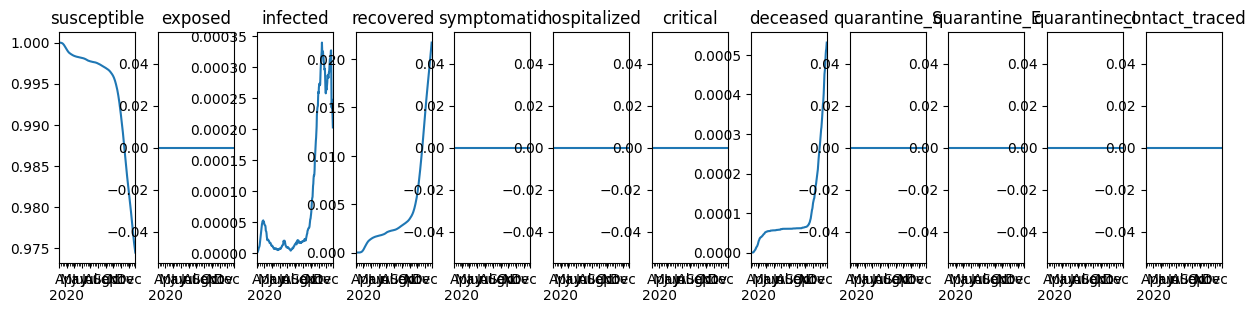

In [4]:
fig, axs = plt.subplots(ncols=12, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(data.columns):
    data[col].plot(ax=axs[idx], title=col)

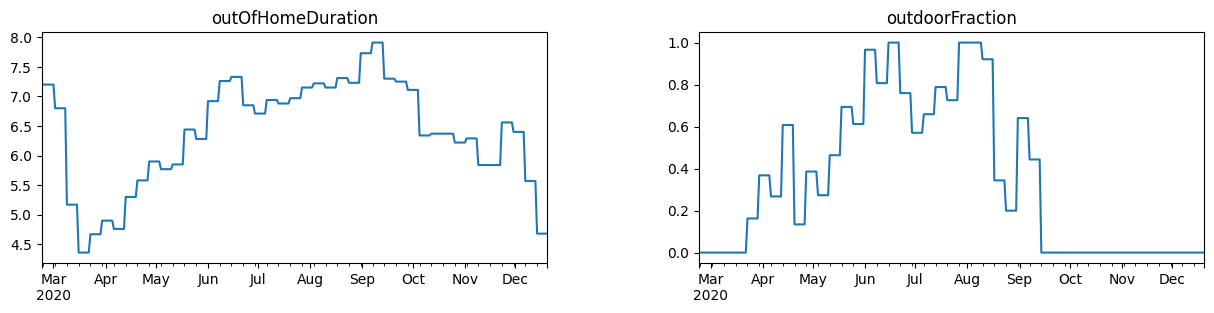

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(weathermob_df.columns):
    weathermob_df[col].plot(ax=axs[idx], title=col)

In [6]:
# Define a simple SIR model
def SIR_model(state: torch.Tensor, parameters: dict) -> torch.Tensor:
    k_Q = 10.25 * parameters["k_CT"] * state[-1]
    new_state = state + torch.stack([(-parameters["k_E"] * state[2] - k_Q)
                                * state[0]
                                + parameters["k_S"] * state[8]
                                + parameters["k_W"] * state[1],

                                parameters["k_E"] * state[0] * state[2]
                                - (parameters["k_I"] + k_Q) * state[1]
                                - parameters["k_W"] * state[1],

                                parameters["k_I"] * state[1]
                                - (parameters["k_R"] + parameters["k_SY"] + k_Q)
                                * state[2],

                                parameters["k_R"]
                                * (
                                    state[2]
                                    + state[4]
                                    + state[5]
                                    + state[6]
                                    + state[10]
                                ),

                                parameters["k_SY"]
                                * (state[2] + state[10])
                                - (parameters["k_R"] + parameters["k_H"])
                                * state[4],

                                parameters["k_H"] * state[4]
                                - (parameters["k_R"] + parameters["k_C"])
                                * state[5],

                                parameters["k_C"] * state[5]
                                - (parameters["k_R"] + parameters["k_D"])
                                * state[6],

                                parameters["k_D"] * state[6],

                                -parameters["k_S"] * state[8]
                                + k_Q * state[0],

                                -parameters["k_I"] * state[9]
                                + k_Q * state[1],

                                parameters["k_I"] * state[9]
                                + k_Q * state[2]
                                - (parameters["k_SY"] + parameters["k_R"])
                                * state[10],

                                parameters["k_SY"] * state[2]
                                - 10.25
                                * torch.sum(state[0:3])
                                * state[-1]]) * parameters['dt']
    return new_state

Small example of the SIR model 
data = [training_data[0] + torch.tensor([0, 0.1, 0])]
for n in range(training_data.shape[0]):
    data.append(SIR_model(data[-1], parameters=dict(k_I=1, k_R=0.1, dt=0.1)))
xr.DataArray(data, dims=["time", "kind"]).plot(col="kind", sharey=False)

In [7]:
data

,susceptible,exposed,infected,recovered,symptomatic,hospitalized,critical,deceased,quarantine_S,quarantine_E,quarantine_I,contact_traced
2020-03-03,0.999998,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-04,0.999997,0,0.000001,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-05,0.999995,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-06,0.999993,0,0.000002,5.287925e-07,0,0,0,2.643962e-07,0,0,0,0
2020-03-07,0.999990,0,0.000003,5.287925e-07,0,0,0,5.287925e-07,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.975428,0,0.000242,2.050982e-02,0,0,0,5.020885e-04,0,0,0,0
2020-12-24,0.975172,0,0.000247,2.079994e-02,0,0,0,5.108135e-04,0,0,0,0
2020-12-25,0.974938,0,0.000231,2.109531e-02,0,0,0,5.142507e-04,0,0,0,0
2020-12-26,0.974706,0,0.000222,2.139929e-02,0,0,0,5.240334e-04,0,0,0,0


In [7]:
# Split into a training and test/prediction set
training_data, test_data = torch.from_numpy(data.values).float()[0:290], torch.from_numpy(data.values).float()[290:300]
alpha = training_data.sum(dim=0)**(-1)
alpha

tensor([3.4645e-03,        inf, 4.4721e+01, 9.2439e-01,        inf,        inf,
               inf, 4.1199e+01,        inf,        inf,        inf,        inf])

In [8]:

for idx in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]:  # E, R, Sy, H, C, qS, qE, qI are dropped
    alpha[idx] = 0
training_data.shape, test_data.shape, alpha.shape

(torch.Size([290, 12]), torch.Size([10, 12]), torch.Size([12]))

In [9]:
# Initialise the neural network
NN = NeuralNet(
    input_size=training_data.shape[1],
    output_size=10, #learn twoo! parameters
    num_layers=10,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={0: 'softplus', -1: 'softplus'}),
    biases=dict(default=[-1, 1]),
    learning_rate=0.002
)
# Reset the optimizer

loss_ts = []

In [10]:
pred_param = []

In [11]:
len(weathermob_data)

302

In [12]:
# Train
n_epochs = 1000
batch_size = 290
write_every = 10
parameters = dict(dt=0.1)

for e in (pbar := tqdm.tqdm(range(n_epochs))):
    
    # Run the model, stopping to update the estimates every n steps
    predicted_data = [training_data[0].clone()]
    start_idx = 0
    epoch_loss = []
    _pred_param = []

    for t in range(training_data.shape[0]):
        
        predicted_parameters = NN(training_data[t])
        
        if e % write_every == 0:
            _pred_param.append(predicted_parameters.clone().detach())
        
        #if t < 30:
        #beta = torch.clamp((predicted_parameters[0]*weathermob_data[t, 0]**predicted_parameters[3] - (predicted_parameters[1]*weathermob_data[t, 0]**predicted_parameters[3])*(weathermob_data[t, 1]+1)), min=0.001)
        current_index = int(min(t, len(weathermob_data) - 1))
        k_E_t = predicted_parameters[1] * (weathermob_data[current_index, 0]**0.5)
        k_W_t = predicted_parameters[2] * weathermob_data[current_index, 1]
        #beta = (predicted_parameters[0]*(weathermob_data[current_index, 0]**(1/2)) - (predicted_parameters[1]*(weathermob_data[current_index, 0]**(0.5))*(weathermob_data[current_index, 1]*(2))))
            #print(beta[0])
        predicted_data.append(SIR_model(predicted_data[-1], 
                                        parameters={'k_S':predicted_parameters[0],
                                                    'k_E': k_E_t[0],
                                                    'k_W': k_W_t[0],
                                                    'k_I': predicted_parameters[3], 
                                                    'k_R': predicted_parameters[4], 
                                                    'k_D': predicted_parameters[5],
                                                    'k_CT': predicted_parameters[6], 
                                                    'k_SY':predicted_parameters[7], 
                                                    'k_H':predicted_parameters[8], 
                                                    'k_C':predicted_parameters[9],
                                                    'dt': torch.tensor(0.1)}))

        if t > 0 and (len(predicted_data) % batch_size == 0):
            
            loss = (
                alpha * ((torch.stack(predicted_data)[1:, :] - training_data[start_idx+1:start_idx+len(predicted_data), :])**2).sum(dim=0)
            ).sum(dim=0)
            loss.backward()

            NN.optimizer.step()
            NN.optimizer.zero_grad()
            start_idx = t
            epoch_loss.append(loss.detach())
            if t < training_data.shape[0] - 1:
                predicted_data = [training_data[t+1].clone()]
    if e % write_every == 0:
        pred_param.append(_pred_param)
    loss_ts.append(np.mean(epoch_loss))
    pbar.set_description(f"Loss: {loss_ts[-1]}")

Loss: 1.5197427273960784e-05: 100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s]


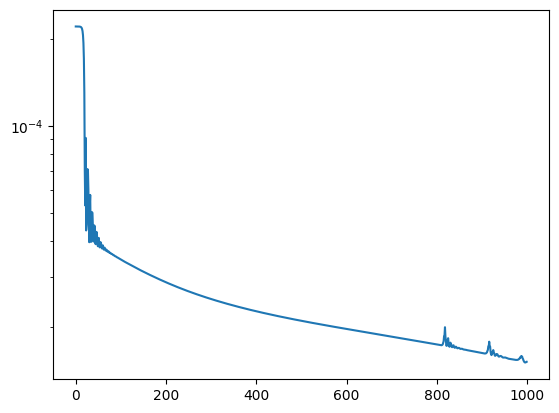

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_ts)
ax.set_yscale('log')

In [14]:
preds = torch.stack([torch.stack(x) for x in pred_param])
preds.shape

torch.Size([100, 290, 10])

IndexError: index 8 is out of bounds for axis 0 with size 8

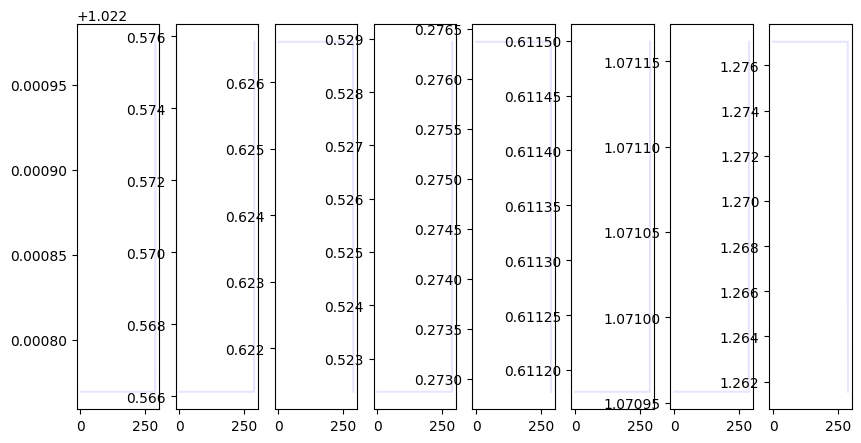

In [15]:
fig, axs = plt.subplots(ncols=8, figsize=(10, 5))
for p in preds:
    for idx, arr in enumerate(p.transpose(0, 1)):
        axs[idx].plot(arr, alpha=0.1, color='blue')

In [16]:
predicted_parameters

tensor([1.5970e-04, 6.8039e-01, 3.1306e-02, 1.6221e+00, 1.2121e-01, 5.0141e-01,
        2.9922e+01, 1.1596e+00, 3.1708e-01, 8.7204e-01],
       grad_fn=<SoftplusBackward0>)

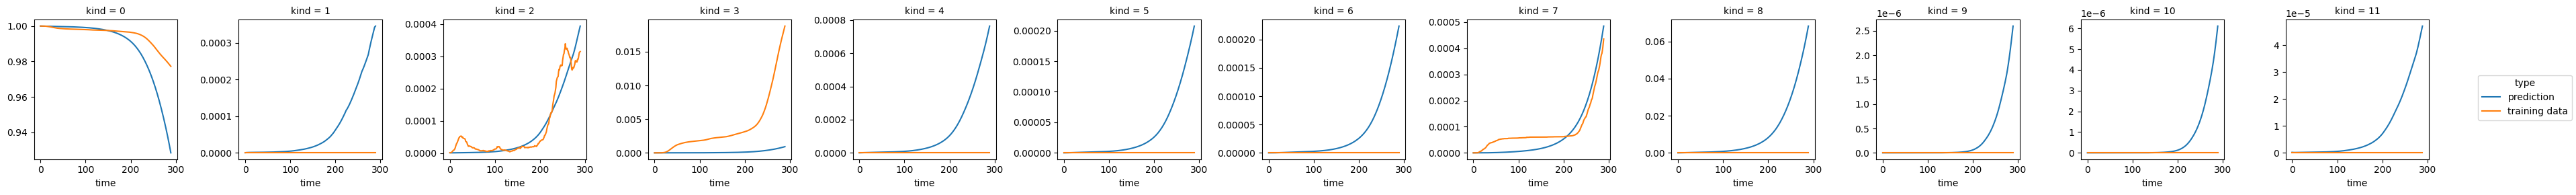

In [17]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    #if t < 100:
    # beta = torch.clamp((
    #         predicted_parameters[0]*weathermob_data[t, 0]**predicted_parameters[3] - (predicted_parameters[1]*weathermob_data[t, 0]**predicted_parameters[3])*(weathermob_data[t, 1]+1))
    #     ,0.6)
    #current_index = int(min(t+145, len(weathermob_data)+145 - 1))
    #beta = (predicted_parameters[0]*(weathermob_data[current_index, 0]**(0.5)) - (predicted_parameters[1]*(weathermob_data[current_index, 0]**(0.5))*weathermob_data[current_index, 1]*(2)))
    # else: 
    #     beta = torch.clamp((
    #             predicted_parameters[4]*weathermob_data[t, 0]**predicted_parameters[6] - (predicted_parameters[5]*weathermob_data[t, 0]**predicted_parameters[6])*weathermob_data[t, 1]),
    #         0.001)
    current_index = int(min(t, len(weathermob_data) - 1))
    k_E_t = predicted_parameters[1] * weathermob_data[current_index, 0]**0.5
    k_W_t = predicted_parameters[2] * weathermob_data[current_index, 1]
    #beta = (predicted_parameters[0]*(weathermob_data[current_index, 0]**(1/2)) - (predicted_parameters[1]*(weathermob_data[current_index, 0]**(0.5))*(weathermob_data[current_index, 1]*(2))))
        #print(beta[0])
    predicted_data.append(SIR_model(predicted_data[-1], 
                                    parameters={'k_S':predicted_parameters[0],
                                                'k_E': k_E_t[0],
                                                'k_W': k_W_t[0],
                                                    'k_I': predicted_parameters[3], 
                                                    'k_R': predicted_parameters[4], 
                                                    'k_D': predicted_parameters[5],
                                                    'k_CT': predicted_parameters[6], 
                                                    'k_SY':predicted_parameters[7], 
                                                    'k_H':predicted_parameters[8], 
                                                    'k_C':predicted_parameters[9], 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

#xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", hue='type', sharey=False)

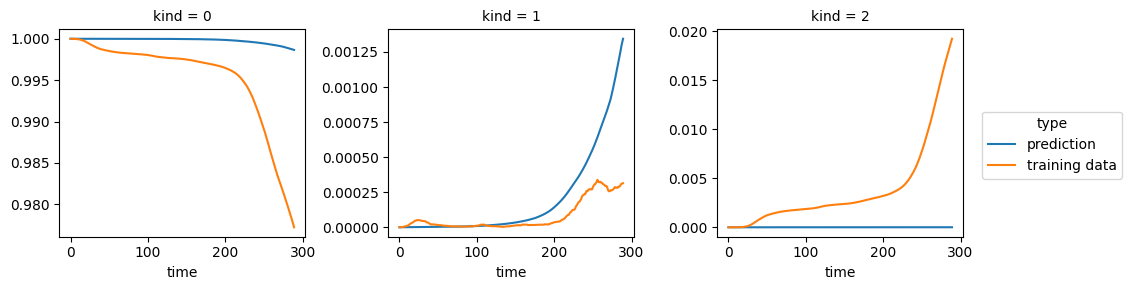

In [27]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    # beta = torch.sigmoid((predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1])
    beta = 0.15*(0.04*(weathermob_data[t, 0]**2) - 0.007*weathermob_data[t, 1]*(weathermob_data[t, 0])**2)
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': 0.001, 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

In [204]:
for t in range(training_data.shape[0]):
    beta = 0.024*weathermob_data[t,0]**2 - (0.005*weathermob_data[t,1]*weathermob_data[t, 0]**2)
    print(beta)

tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([7.3379])

In [67]:
NN(training_data[t])

tensor([4.8106e-03, 7.8599e-05, 2.7032e+00], grad_fn=<SoftplusBackward0>)

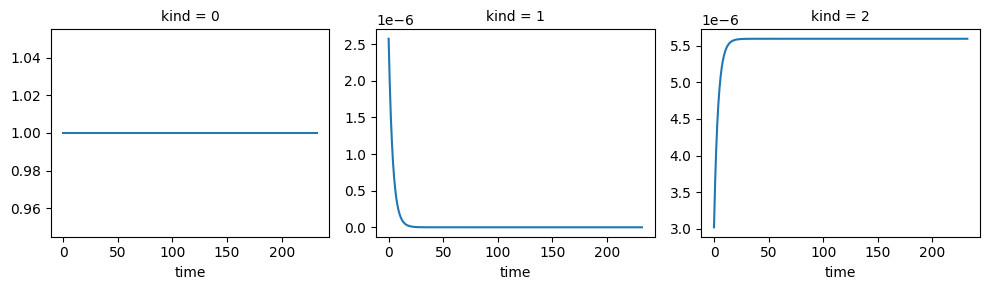

In [247]:
xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", sharey=False)

In [56]:
len(predicted_data)

210

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Create a toy DataFrame with weather and mobility data
data = {
    'time': np.arange(0, 50, 1),  # Time points
    'weather': np.random.uniform(0.1, 0.9, 50),  # Random weather data (e.g., fraction of good weather)
    'mobility': np.random.uniform(0.5, 1.5, 50)  # Random mobility data (e.g., time spent out of home)
}

df = pd.DataFrame(data)
print(df.head())


   time   weather  mobility
0     0  0.758853  0.664688
1     1  0.289212  0.525703
2     2  0.236241  0.745787
3     3  0.754888  1.146519
4     4  0.864464  1.223223


0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.7091712
0.5974207999999999
0.5974207999999999
0.5974207999

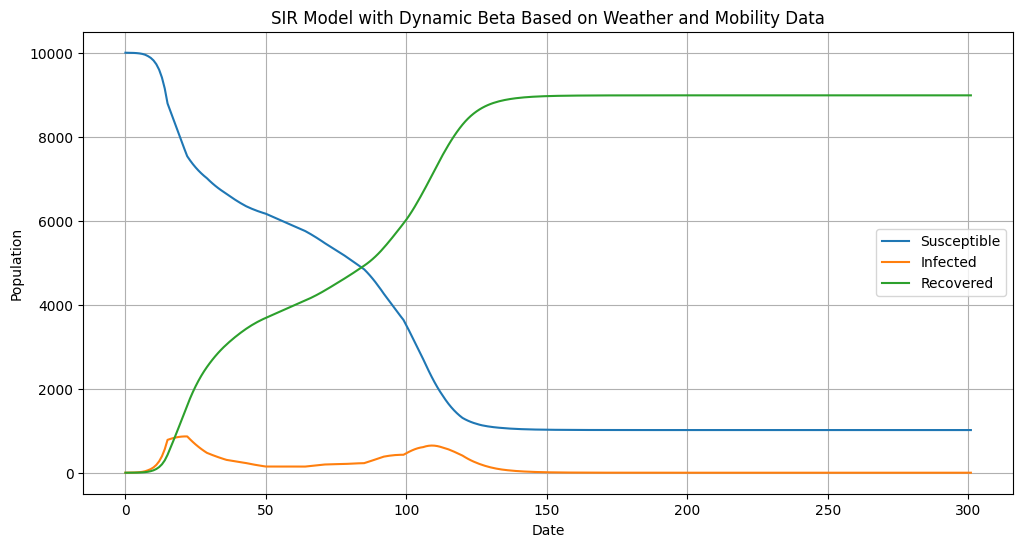

In [363]:
# Define parameters for beta calculation
par1 = 0.0024  # Parameter 1 for beta calculation (adjustable)
par2 = 0.0005  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration**3- par2 * outdoor_fraction * out_of_home_duration**3
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    print(beta)
    gamma = 0.2  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()


tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.7092)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.5974)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.2626)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.1575)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2018)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2452)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.2193)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3281)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.3418)
tensor(0.4298)
tensor(0.4298)
tensor(0.4

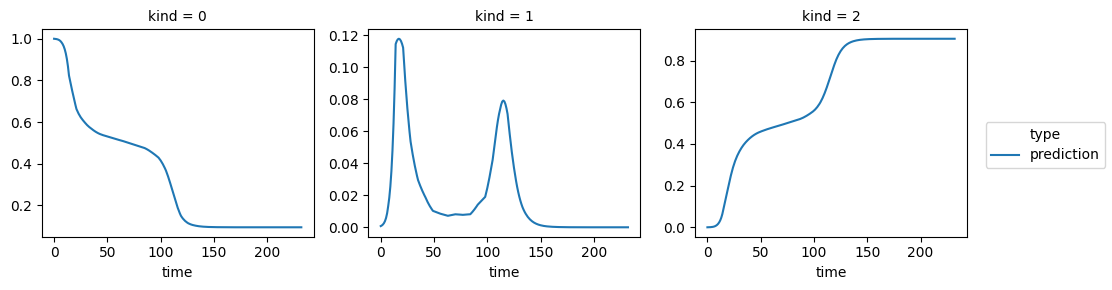

In [367]:
predicted_data = [torch.tensor([0.9999, 0.0005, 0])]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    beta = torch.clamp((
            0.0024*weathermob_data[t, 0]**3 - (0.0005*weathermob_data[t, 1]*weathermob_data[t, 0]**3))
        ,0.001)
    print(beta[0])
    #beta = predicted_parameters[0] + weathermob_data[t, 0]*predicted_parameters[1]
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': 0.2, 'dt': torch.tensor(1)}))
xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", hue='type', sharey=False)

In [394]:
training_data[0]

tensor([9.9998e-01, 3.3570e-06, 2.2380e-06])

0.0 0
8.359410289326325e-05 0
8.359410289326325e-05 0
0.0001671882057865265 0
0.0001671882057865265 0
0.004744914480095001 0
0.004744914480095001 0
0.009322640754403477 0
0.009322640754403477 0
0.013900367028711953 0
0.013900367028711953 0
0.03433155662964071 0
0.03433155662964071 0
0.028804859703994802 0
0.028804859703994802 0
0.04370935237927765 0
0.04370935237927765 0
0.041221780571048916 0
0.041221780571048916 0
0.05363870143810302 0
0.05363870143810302 0
0.06605562230515713 0
0.06605562230515713 0
0.07847254317221124 0
0.07847254317221124 0
0.10330638490631947 0
0.10330638490631947 0
0.12814022664042768 0
0.12814022664042768 0
0.1529740683745359 0
0.1529740683745359 0
0.1778079101086441 0
0.1778079101086441 0
0.20264175184275232 0
0.20264175184275232 0
0.2923237879636847 0
0.2923237879636847 0
0.38200582408461703 0
0.38200582408461703 0
0.4716878602055494 0
0.4716878602055494 0
0.5613698963264818 0
0.5613698963264818 0
0.6510519324474142 0
0.6510519324474142 0
0.7407339685683466 0

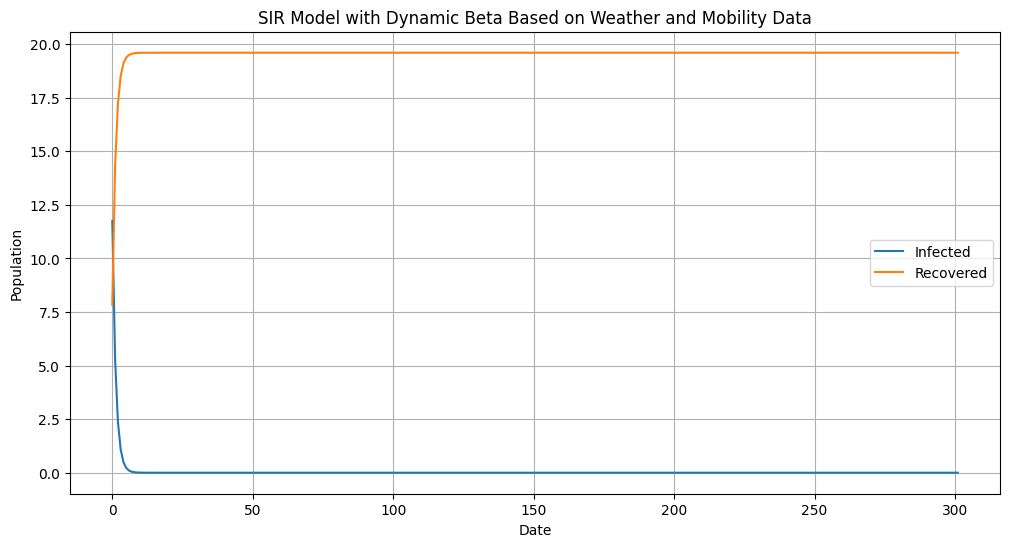

In [415]:
# Define parameters for beta calculation
par1 = 0.5963  # Parameter 1 for beta calculation (adjustable)
par2 = 0.9230  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 3500000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 3.3570e-06*N, 2.2380e-06*N
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = (par1 * out_of_home_duration**1.0796- par2 * outdoor_fraction * out_of_home_duration**1.0796)
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    print(t, current_index)
    gamma = 0.8  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()

In [411]:
t 

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.4402047999999999
0.4402047999999999
0.4402047999999999
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.5225472
0.4402047999999999
0.4402047999999999
0.4402047999999999
0.44020479999999

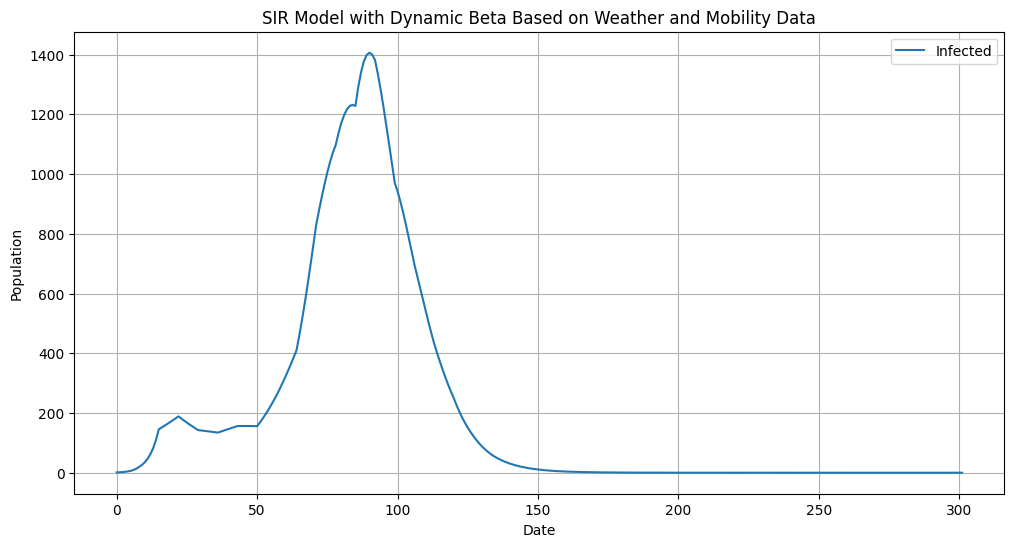

In [431]:
# Define parameters for beta calculation
par1 = 0.0024  # Parameter 1 for beta calculation (adjustable)
par2 = 0.0005  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration**3- par2 * outdoor_fraction * out_of_home_duration**3
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction']+1, par1, par2)
    print(beta)
    gamma = 0.15  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
#plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()


In [7]:
GF = []
weathermob_df["outdoorFraction"] = abs(weathermob_df["outdoorFraction"] - 2)

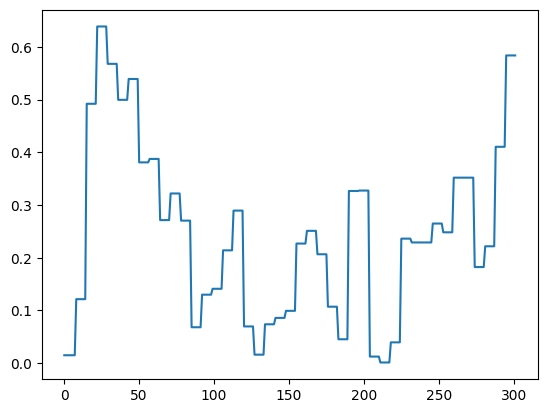

In [13]:
GF = []
for t in range(len(weathermob_df)):
    gft = 0.024 * (weathermob_data[t, 0]**2) - 0.005*weathermob_data[t, 1]*(weathermob_data[t, 0]**2)
    GF.append(abs(gft-1))
plt.plot(GF)

In [11]:
weathermob_df

,outOfHomeDuration,outdoorFraction
2020-02-23,7.20,1.0
2020-02-24,7.20,1.0
2020-02-25,7.20,1.0
2020-02-26,7.20,1.0
2020-02-27,7.20,1.0
...,...,...
2020-12-16,4.68,1.0
2020-12-17,4.68,1.0
2020-12-18,4.68,1.0
2020-12-19,4.68,1.0


In [115]:
from scipy.integrate import odeint

In [174]:
weathermob_df_re = weathermob_df.reset_index()
weathermob_df_re["outdoorFraction"] = abs(weathermob_df_re["outdoorFraction"] - 2)*2

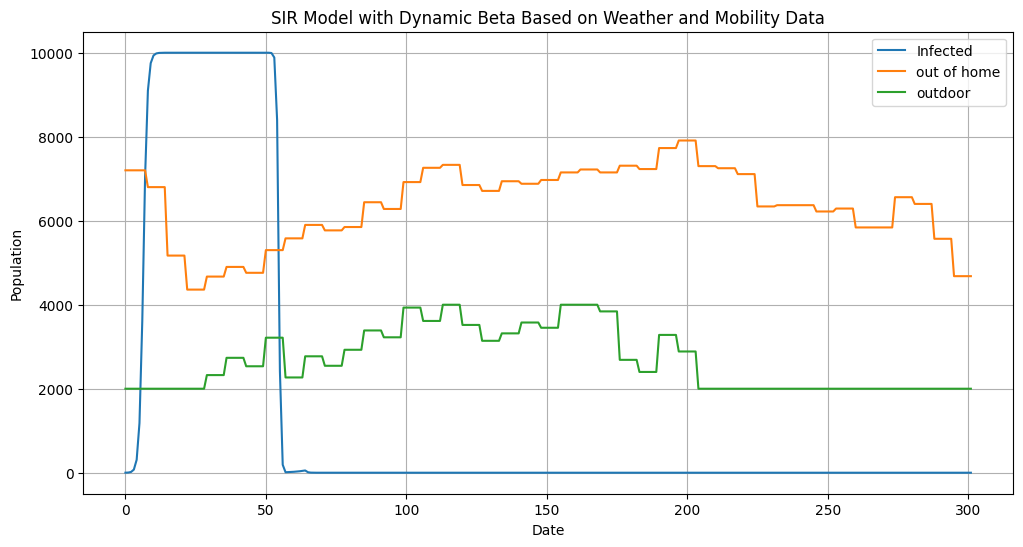

In [200]:
# Define parameters for beta calculation
par1 = 1.2 # Parameter 1 for beta calculation (adjustable)
par2 = 0.6  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration- par2 * outdoor_fraction * out_of_home_duration
    return beta  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def si_model(y, t, N, par1, par2, df):
    S, I = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N 
    return dSdt, dIdt

# Initial conditions vector
y0 = S0, I0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df_re))

# Integrate the SIR equations over the time grid, t
result = odeint(si_model, y0, t, args=(N, par1, par2, weathermob_df_re))

# Extract the results
S, I = result.T

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(weathermob_df_re.reset_index().outOfHomeDuration * 1000, label='out of home')
plt.plot(weathermob_df_re.reset_index().outdoorFraction * 1000, label='outdoor')
#plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()


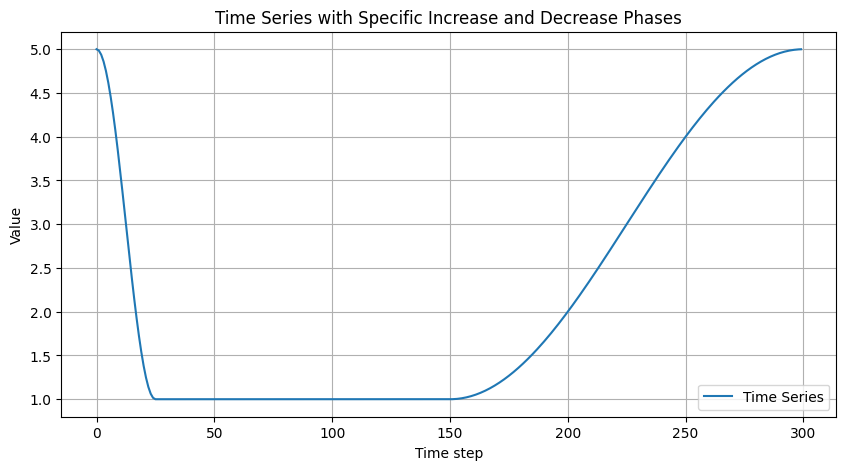

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Define the total number of time steps
n_steps = 300

# Create time steps
t = np.arange(0, n_steps)

# Initialize the data array
data = np.ones(n_steps) * 1  # Default value is 1

# First transition (decrease): using a cosine easing for smoothness
transition_length = 25
start_decrease = 5
end_decrease = 1
data[:transition_length] = start_decrease + (end_decrease - start_decrease) * (1 - np.cos(np.pi * t[:transition_length] / transition_length)) / 2

# Last transition (increase): using a cosine easing for smoothness
start_increase = 150
end_increase = n_steps
start_value = 1
end_value = 5
data[start_increase:end_increase] = start_value + (end_value - start_value) * (1 - np.cos(np.pi * (t[start_increase:end_increase] - start_increase) / (end_increase - start_increase))) / 2

# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(t, data, label='Time Series')
plt.title('Time Series with Specific Increase and Decrease Phases')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

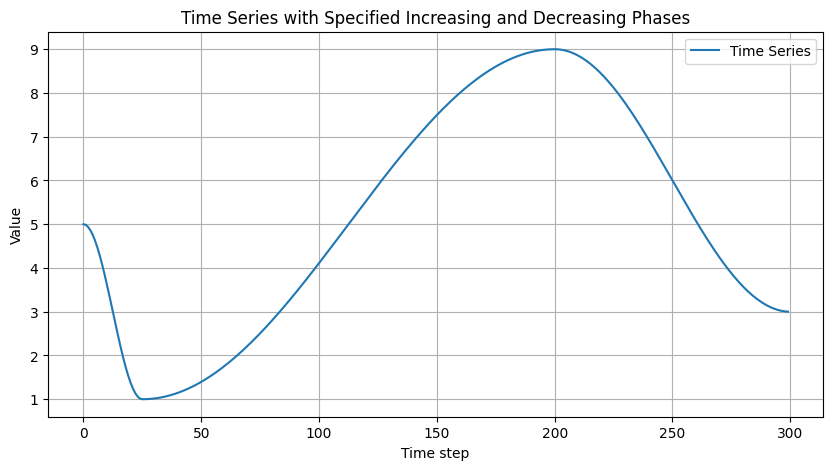

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Define the total number of time steps
n_steps = 300

# Create time steps
t = np.arange(0, n_steps)

# Initialize the data array
D = np.ones(n_steps) * 1  # Starts off at the lowest value

# Transition details
initial_value = 5
minimum_value = 1
peak_value = 9
final_value = 3

# First transition (decrease): using a cosine easing for smoothness
first_transition_end = 25
D[:first_transition_end] = initial_value + (minimum_value - initial_value) * (1 - np.cos(np.pi * t[:first_transition_end] / first_transition_end)) / 2

# Second transition (increase): Gradually increase to 5 by t=200 using a cosine easing
second_transition_start = 25
second_transition_end = 200
D[second_transition_start:second_transition_end] = minimum_value + (peak_value - minimum_value) * (1 - np.cos(np.pi * (t[second_transition_start:second_transition_end] - second_transition_start) / (second_transition_end - second_transition_start))) / 2

# Third transition (decrease): Decrease to 3 by t=300 using a cosine easing
third_transition_start = 200
third_transition_end = 300
D[third_transition_start:third_transition_end] = peak_value + (final_value - peak_value) * (1 - np.cos(np.pi * (t[third_transition_start:third_transition_end] - third_transition_start) / (third_transition_end - third_transition_start))) / 2

# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(t, D, label='Time Series')
plt.title('Time Series with Specified Increasing and Decreasing Phases')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

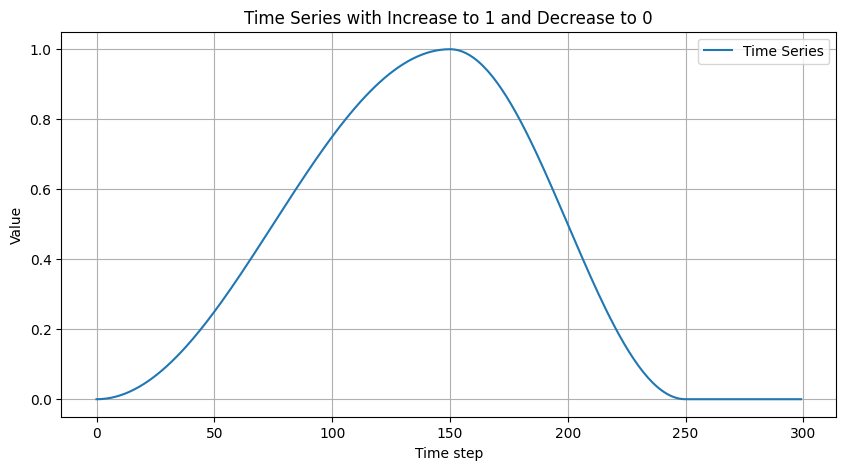

In [348]:
import numpy as np
import matplotlib.pyplot as plt

# Define the total number of time steps
n_steps = 300

# Create time steps
t = np.arange(0, n_steps)

# Initialize the data array with zeros
outFrac = np.zeros(n_steps)

# Increase to 1 by t=150 using a cosine easing
increase_end = 150
outFrac[:increase_end] = 0.5 - 0.5 * np.cos(2 * np.pi * t[:increase_end] / (2 * increase_end))

# Decrease back to 0 by t=200 using a cosine easing
decrease_start = 150
decrease_end = 250
outFrac[decrease_start:decrease_end] = 1 - 0.5 + 0.5 * np.cos(2 * np.pi * (t[decrease_start:decrease_end] - decrease_start) / (2 * (decrease_end - decrease_start)))

# Remain at 0 from t=200 onwards (already initialized to 0)

# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(t, outFrac, label='Time Series')
plt.title('Time Series with Increase to 1 and Decrease to 0')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

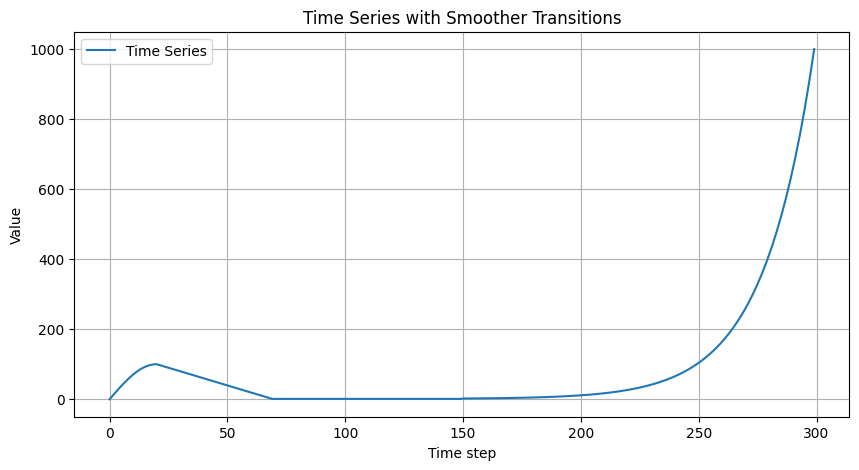

In [217]:
import numpy as np
import matplotlib.pyplot as plt

# Define the total number of time steps
n_steps = 300

# Create time steps
t = np.arange(0, n_steps)

# Initialize the data array with zeros
inf = np.zeros(n_steps)

# First phase: smooth increase from 0 to 100 in the first 20 time steps (using sine easing)
first_phase_end = 20
inf[:first_phase_end] = 100 * np.sin(np.pi * t[:first_phase_end] / (2 * first_phase_end))

# Second phase: linear decrease to 1 over the next 50 time steps
second_phase_start = 20
second_phase_end = 70
inf[second_phase_start:second_phase_end] = np.linspace(100, 1, second_phase_end - second_phase_start)

# Third phase: stay at 1 until t=150
third_phase_start = 70
third_phase_end = 150
inf[third_phase_start:third_phase_end] = 1

# Fourth phase: exponential increase to 1000, starting at t=150
fourth_phase_start = 150
fourth_phase_end = 300
inf[fourth_phase_start:fourth_phase_end] = np.exp(np.linspace(0, np.log(999), fourth_phase_end - fourth_phase_start)) + 1

# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(t, inf, label='Time Series')
plt.title('Time Series with Smoother Transitions')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

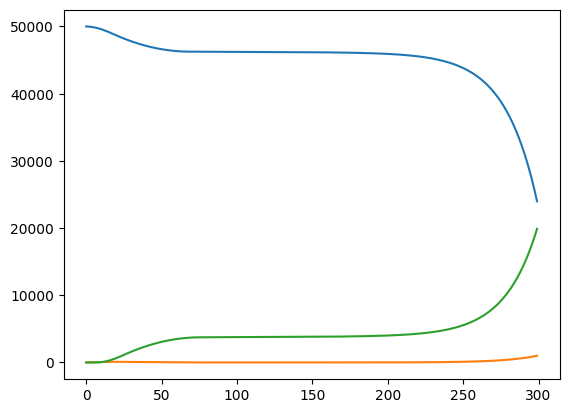

In [226]:

accumulated_inf = np.cumsum(inf)
rec = np.zeros(n_steps)

# Simulate recovery after 10 days
rec_delay = 7
for i in range(rec_delay, n_steps):
    rec[i] = rec[i - 1] + inf[i - rec_delay]
    
sus = 50000 - accumulated_inf

plt.plot(sus)
plt.plot(inf)
plt.plot(rec)

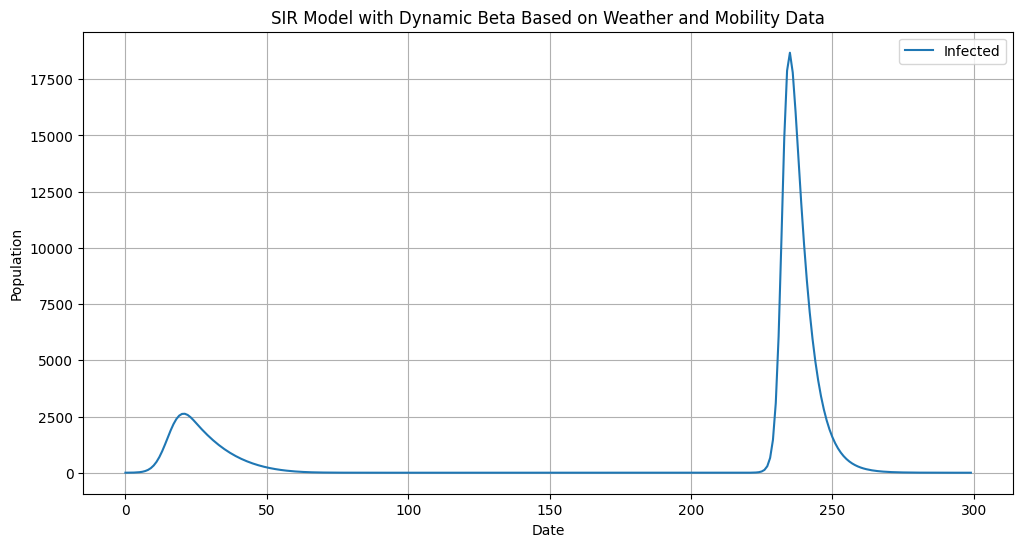

In [360]:
# Define parameters for beta calculation
par1 = 0.17  # Parameter 1 for beta calculation (adjustable)
par2 = 2.21  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 50000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, rec[0]
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = (par1 * out_of_home_duration - par2*(outdoor_fraction**2))
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(inf) - 1))
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(D[current_index], outFrac[current_index], par1, par2)
    gamma = 0.2  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(inf))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
#plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()


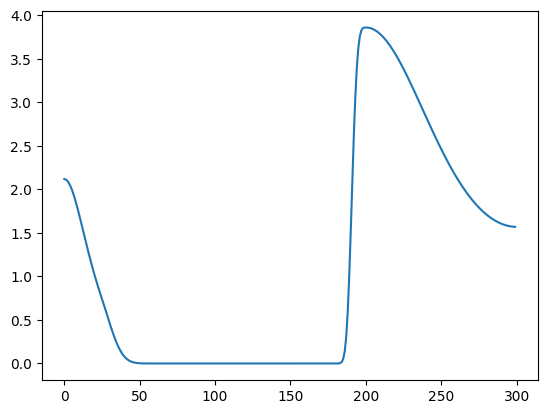

In [347]:
plt.plot(np.exp((0.15 * D) - 100 * (outFrac**2)))

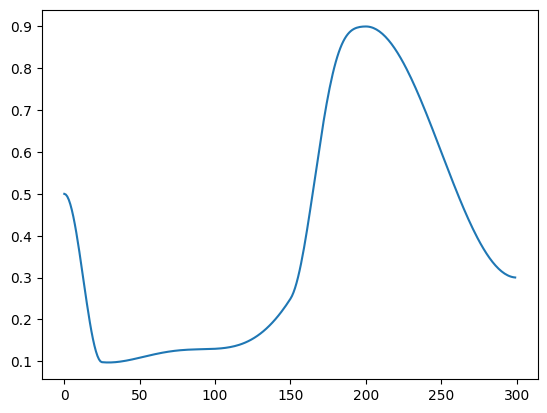

In [301]:
plt.plot(0.1 * D - 0.5*(outFrac**2))